In [2]:
import os
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
import tensorflow_probability as tfp
from jax import jit
import datetime

tfp = tfp.experimental.substrates.jax
tfd = tfp.distributions
import numpy as onp
import tensorflow_datasets as tfds
import jax
from jax import vmap
import neural_tangents as nt
from neural_tangents.predict import gradient_descent_mse_ensemble
from functools import partial
import time
import pandas as pd
import jax.numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
from skimage.util import random_noise


In [4]:
from tqdm import tqdm

In [5]:
!echo $XLA_FLAGS$

$


In [6]:
@jit
def get_info_nec(gauss, tlbs, init_pred=None, beta=0, num_of_samples=2, th=1e-10):
    """I(X:Z) estimator"""
    rng = jax.random.PRNGKey(0)
    mu, sig = gauss
    pzx = tfd.Independent(distribution=tfd.MultivariateNormalDiag(mu, np.tile(sig + th, (mu.shape[1], 1)).T))
    samples = pzx.sample(seed=rng, sample_shape=1)
    log_prob_pxt = pzx[:, None].log_prob(samples[0, :, :])
    im_lower = inner_info_nec_lower(log_prob_pxt)
    im_upper = inner_info_nec_upper(log_prob_pxt)
    return IXT_MET(ixt_lower=im_lower, ixt_upper=im_upper)


@jit
def remove_dig(A):
    return A[~onp.eye(A.shape[0], dtype=bool)].reshape(A.shape[0], -1)


@jit
def inner_info_nec_lower(scores):
    """InfoNCE estimator for I(diX;T)  - van den Oord et al. (2018):"""
    nll = np.mean(np.diag(scores) - jax.scipy.special.logsumexp(scores, axis=1))
    K = scores.shape[1]
    mi = np.log(K) + nll
    return mi


@jit
def inner_info_nec_upper(scores):
    """InfoNCE estimator for I(diX;T)  - van den Oord et al. (2018):"""
    scores_no_diagonal = remove_dig(scores)
    nll = np.mean(np.diag(scores) - jax.scipy.special.logsumexp(scores_no_diagonal, axis=1))
    K = scores.shape[1]
    mi = np.log(K - 1) + nll
    return mi


@jit
def get_kl_posterior_prior(gauss, tlbs, init_gauss=None, beta=0, th=1e-10):
    """The dkl between the posterior and the prior distribution of the output -upper bound on I(Z;D|X)"""
    mu, sig = gauss
    init_mu, init_sig = init_gauss
    pzx = tfd.Independent(distribution=tfd.MultivariateNormalDiag(mu, np.tile(sig + th, (mu.shape[1], 1)).T))
    pzx_init = tfd.Independent(
        distribution=tfd.MultivariateNormalDiag(init_mu, np.tile(init_sig + th, (mu.shape[1], 1)).T))
    kl = tfp.distributions.kl_divergence(pzx, pzx_init)
    return DKL_MET(dkl_output=np.mean(kl))



@jit
def get_bayes_loss(gauss, tlbs, th=1e-15):
    mu, sig = gauss
    pyz = tfd.Independent(distribution=tfd.MultivariateNormalDiag(mu, np.tile(sig + th, (mu.shape[1], 1)).T))
    return pyz.log_prob(tlbs).mean()


@jit
def loss_fn(loss_train, tlbs, m):
    mean, var = loss_train
    mean = np.reshape(mean, mean.shape[:1] + (-1,))
    mean_predictions = - 0.5 * np.mean(tlbs ** 2 - 2 * mean * tlbs + mean ** 2,
                                       axis=1)
    third_term = 0.5 * np.log(2 * np.pi)
    fourth_term = 0.5 * (np.log(1 + var))
    fifth_term = -0.5 * var
    return np.mean(third_term + fourth_term + mean_predictions + fifth_term)


@jit
def loss_fn_vib(loss_train, tlbs, beta):
    """Returns all the elements of the vib-ntk loss"""
    mean, var = loss_train
    mean = np.reshape(mean, mean.shape[:1] + (-1,))
    mean_predictions = 0.5 * np.mean(tlbs ** 2 - 2 * mean * tlbs + mean ** 2,
                                     axis=1)
    term = 0.5 * beta * mean ** 2
    third_term = 0.5 * var
    return np.mean(mean_predictions), np.mean(term), np.mean(third_term)


@jit
def get_losses(gauss, tlbs, init_gauss=None, beta=0):
    """Return all the ;oasses"""
    tcut = tlbs.shape[1]
    gibbs_loss = loss_fn(gauss, tlbs, tcut)
    bayes_loss = get_bayes_loss(gauss, tlbs, tcut)
    mean_pred, beta_term, trace_term = loss_fn_vib(gauss, tlbs, beta)
    return LOSS_MET(bayes_loss=bayes_loss, gibbs_loss=gibbs_loss, mean_pred=mean_pred,
                    beta_term=beta_term, trace_term=trace_term)



def calc_metrics(t, predict_fn, init_preds, beta):
    """Calculate info metrics based for the given time for both train and test."""
    trains = [train_images, train_labels, 'train']
    tests = [test_images, test_labels, 'test']
    data = [trains, tests]
    dict_val = {}
    for data_part, init_pred in zip(data, init_preds):
        images, labels, name = data_part
        pred = predict_fn(t=t, x_test=images)
        for metric_dict in metrics_func:
            metric_names = metric_dict.names
            metric_func_inner = metric_dict.func
            metric_val = metric_func_inner(pred, labels, init_pred, beta)
            for metric_name in metric_names:
                val = getattr(metric_val, metric_name)
                dict_val['{}_{}'.format(metric_name, name)] = val
    return dict_val

In [7]:
def process(arr, covnet):
    return arr ### no need to change the shape. orginal code changes shaped based on cnn/dense layers


def load_data(train_images, train_labels,test_images, test_labels, test_size, covnet=False, nb_classes=10, binary_labels=True):
#     (train_images, train_labels), (test_images, test_labels) = tfds.as_numpy(tfds.load(
#         dataset, split=['train', 'test'], batch_size=-1, as_supervised=True))
    #print(train_images.shape)
    train_images = process(train_images, covnet)
    #print(train_images.shape)
    test_images = process(test_images, covnet)
#     train_images = train_images[:train_size]
#     train_labels = train_labels[:train_size]
    test_images = test_images[:test_size]
    test_labels = test_labels[:test_size]
    train_labels = 2 * (train_labels % 2 == 0) - 1
    test_labels = 2 * (test_labels % 2 == 0) - 1

    return train_images, train_labels[:, None].astype('float32'), test_images, test_labels[:, None].astype('float32')


In [8]:
def gradient_descent_mse_vib(beta, train_images, train_labels, diag_reg, ker_fn):
    # In vib-ntk with fixed prior and fixed covariance for the encoder we need to scale Y with (1+beta)
    # and to scale the time
    new_train_labels = train_labels / (1 + beta)
    predict_fn = gradient_descent_mse_ensemble(kernel_fn=ker_fn, x_train=train_images, y_train=new_train_labels,
                                               diag_reg=diag_reg)

    # Scale it by t+1
    def predict_fn_lam(t, x_test, get, compute_cov):
        mean = predict_fn(t=t * (1 + beta), x_test=x_test, get=get, compute_cov=compute_cov)
        if not compute_cov:
            sig = np.ones([len(mean), ])
        else:
            mean, sig = mean
            sig = np.diag(sig)
        return mean, sig
    return predict_fn_lam


def maker(beta=0, w_std=0.8, t=0, b_std=0, diag_reg=1e-4, compute_cov=False):
    init_fn, apply_fn, ker_fn = nt.stax.serial(
#             nt.stax.Conv(1, (3,3), W_std=w_std, b_std=b_std),
#             nt.stax.Relu(),
#             nt.stax.AvgPool((8,8)),
        
#             nt.stax.Conv(1, (3,3), W_std=w_std, b_std=b_std),
#             nt.stax.Relu(),
#             nt.stax.AvgPool((4,4)),
        
# #             nt.stax.Conv(6, (3,3), W_std=w_std, b_std=b_std),
# #             nt.stax.Relu(),
# #             nt.stax.AvgPool((4,4)),
            
#             nt.stax.Flatten(),
        
#             nt.stax.Dense(1, W_std=w_std, b_std=b_std))
            
            nt.stax.Dense(512, W_std=w_std, b_std=b_std),
            nt.stax.Relu(),
            nt.stax.Dense(128, W_std=w_std, b_std=b_std),
            nt.stax.Relu(),
            nt.stax.Dense(32, W_std=w_std, b_std=b_std),
            nt.stax.Relu(),
            nt.stax.Dense(1, W_std=w_std, b_std=b_std))
        
    ker_fn = nt.batch(ker_fn, batch_size=batch_size, device_count=num_of_gpus, store_on_device=True)
        
        
    predict_fn = gradient_descent_mse_vib(beta, train_images, train_labels, diag_reg, ker_fn)
    predict_fn = partial(predict_fn, get='ntk', compute_cov=compute_cov)
    init_pred_train = predict_fn(t=0, x_test=train_images)
    init_pred_test = predict_fn(t=0, x_test=test_images)
    return calc_metrics(t, predict_fn=predict_fn, init_preds=[init_pred_train, init_pred_test], beta=beta)

In [9]:
loss_metrics_name = ['bayes_loss', 'gibbs_loss', 'mean_pred', 'beta_term', 'trace_term']
vib_loss_metrics_name = ['vib_bayes_loss', 'vib_gibbs_loss']
ixt_metrics_name = ['ixt_lower', 'ixt_upper']
vib_ixt_metrics_name = ['vib_ixt_lower', 'vib_ixt_upper']
dkl_metrics_name = ['dkl_output']
dist_metrics_name = ['parameter_distance']
itd_metrics_name = ['i_theta_data']
LOSS_MET = collections.namedtuple('loss_metrics', loss_metrics_name)
IXT_MET = collections.namedtuple('ixt_metrics', ixt_metrics_name)
DKL_MET = collections.namedtuple('dkl_output', dkl_metrics_name)
DIST_MET = collections.namedtuple('parameter_distance', dist_metrics_name)
ITD_MET = collections.namedtuple('i_theta_data', itd_metrics_name)

MetricsTuple = collections.namedtuple('metrics', tuple(['names', 'func']))
metrics = {
    'losses': MetricsTuple(tuple(loss_metrics_name), get_losses),
    'ixt': MetricsTuple(tuple(ixt_metrics_name), get_info_nec),
    'dkl_output': MetricsTuple(tuple(dkl_metrics_name), get_kl_posterior_prior)
}

In [10]:
dataset = 'MNIST'
net_type = 'FC'
train_size = 4000
test_size = 1000
batch_size = 250


ts_min = -3
ts_max = 20
num_ts = 2

sigs_min = -4
sigs_max = 2.2
num_sigs = 30

beta_min = -15
beta_max = 2
num_betas = 30

num_of_gpus = 4
b_std = 0.
dig_reg = 1e-4
run_metrics = ['losses', 'ixt', 'dkl_output']
params = {'train_size': train_size, 'test_size': test_size, 'dataset': dataset, 'net_type': net_type,
          'ts_min': ts_min, 'ts_max': ts_max, 'b_std': b_std, 'num_ts': num_ts, 'sigs_min': sigs_min,
          'sigs_max': sigs_max,
          'num_sigs': num_sigs, 'dig_reg': dig_reg, 'batch_size': batch_size}

In [11]:
metrics_func = tuple([metrics[key] for key in run_metrics if key in metrics])
ts = np.logspace(ts_min, ts_max, num_ts)
sigs = np.logspace(sigs_min, sigs_max, num_sigs)
betas = np.logspace(beta_min, beta_max, num_betas)

# changed jax.np logspcae to originla np. 

In [13]:
ts = np.linspace(1e-1,1e+4, num = 1000)

In [14]:
def add_white_path(image, loc_x, loc_y):
    #add a 3*3 white patch at loc_x,loc_y
    image = image.reshape(28,28)
    for x in range(3):
        for y in range(3):
            image[loc_x-1+x, loc_y-1+y] = 1
        
    
    return image.reshape(-1)
    

In [15]:
x_train = onp.load('mnist_shortcut_dataset/mnist_x_train_orginal.npy')
x_label = onp.load('mnist_shortcut_dataset/y_train_original.npy')

In [16]:
x = add_white_path(x_train[23], 26,26)


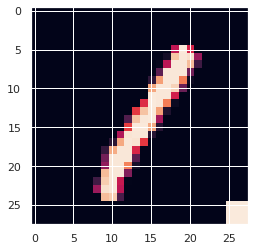

In [17]:
plt.imshow(x.reshape(28,28))

In [18]:
def corr_images(x_train, y, ratio):
    # ratio is between 0-1
    for i in [0,2,4,6,8]:
        
        idx = onp.where(y == i)[0]
        onp.random.shuffle(idx)
        
        #select images accorting the ratio for adding shortcut
        print(idx)
        num_corr = int(ratio*len(idx))
#         print(i, num_corr)
        for j in range(num_corr):

            x_train[idx[j]] = add_white_path(x_train[idx[j]], 26, 26)
            
            
        
        
    return x_train
        
    

In [19]:
def sample_dataset(x,y,size): # returns a balanced dataset 
    
    class_size = size//10 ## mnist has 10 clasees 

    temp_x = []
    temp_y = []
    
    for i in range(10):
        
        idx = onp.where(y==i)[0][:class_size]
        temp_x.append(x[idx].reshape(-1,784))
        temp_y.append(y[idx])
        

    temp_x = onp.array(temp_x).reshape(-1,784)
    temp_y = onp.array(temp_y).reshape(-1)
    
#     print(temp_x.shape)
#     print(temp_y.shape)

    shuffle_idx = onp.arange(size)
    onp.random.shuffle(shuffle_idx)
    
    
    
    return temp_x[shuffle_idx], temp_y[shuffle_idx]
    

In [36]:


ratio_effect = [0.6,0.7,0.8,0.9,1]

for ratio in ratio_effect:
    
    print('===== Training with shortcut effectiveness =', ((ratio)*100), '%')
    
    # load noise train images:
    x_data = onp.load('mnist_shortcut_dataset/mnist_x_train_orginal.npy')

    #load corresponding original label:
    x_label = onp.load('mnist_shortcut_dataset/y_train_original.npy')
    
    ## sample balanced training dataset 
    
    
    x_train, y_train = sample_dataset(x_data, x_label, train_size)
    
    
    #corrupt_images

    x_train = corr_images(x_train, y_train, ratio)
    

    
    ##convert labels to odd/even classes
    y_train = y_train%2

    #load clean test data and labels
    x_test = np.load('mnist_shortcut_dataset/mnist_x_test_ood.npy')
    y_test = np.load('mnist_shortcut_dataset/mnist_y_test_ood.npy')
    x_test = x_test.reshape(-1,784)
    
    train_images, train_labels, test_images, test_labels = load_data(x_train,y_train, x_test, y_test,
                                                                    test_size=test_size)

    
    output = []

    for time in tqdm(ts):

        output.append(maker(beta=0.2, w_std=1.5, t=time, b_std=0, diag_reg=1e-4, compute_cov=False))
        
#     np.save('experiments_outputs_logs/single_patch_effectiveness/effectiveness_' + str((ratio)*100), output )
    

===== Training with shortcut effectiveness = 60.0 %


  1%|          | 11/1000 [01:20<1:59:53,  7.27s/it]

KeyboardInterrupt



In [19]:

# load noise train images:
x_data = onp.load('mnist_shortcut_dataset/mnist_x_train_orginal.npy')

#load corresponding original label:
x_label = onp.load('mnist_shortcut_dataset/y_train_original.npy')

## sample balanced training dataset 


x_train, y_train = sample_dataset(x_data, x_label, train_size)


#corrupt_images


#corrupt with 90% effective noise
x_train = corr_images(x_train, y_train, 0.9)


    
##convert labels to odd/even classes
y_train = y_train%2

#load clean test data and labels
x_test = np.load('mnist_shortcut_dataset/mnist_x_test_ood.npy')
y_test = np.load('mnist_shortcut_dataset/mnist_y_test_ood.npy')
x_test = x_test.reshape(-1,784)

train_images, train_labels, test_images, test_labels = load_data(x_train,y_train, x_test, y_test,
                                                                test_size=test_size)

[1807 2559 1590  283 1574 1667  848  398 1669 1381 3119 3994 3952 1723
  966 2981 1184 3276 3714 2757 1319 1313 3569 1284 1215 3826 3861 1929
 2545   27 2036 3405 3433 2822  516 1224 1268 3649 2631 2374 3559 1783
 1982 1707  429  132  108  479 2265 2181  464 3794 3035   14  912 2926
 3959 2386 3492 1678 2764 1864 3982 1745 1510   77  536   15 2206 2397
  644 3419 1944 1945  669 1213 3622  913 3064 2562 2268 2090 3532 1823
 1099  507 2835 2807 1041 2249 2607 2796 1751 2528 2620 1290  281 3608
 2864 3806 2399 3996 3764  148 2855 3553 3303  648 3292  502 1871  473
 3172 2008 3519  336  123 2003  182 2406  583 1960 3624 1428 3681  400
 3505 3101 2380 2142 3710 2827  572 1281 2825 2555 1091 3062 2840 1432
 3386 3750 3221 3595 3137  555 2971  291 1080 1570 2292    6 3536 1555
 1145   22 1812 1537  419 2418  477 2534 2025  235 1055  518 3468 2937
  614 2311 1971 2954 1475 3525 1033  423 2413 1987 1094 2197 3929  973
 1625 2539  821 2537  687 2075 2250 1340 2462  141 3691  531 2638 2779
 3272 

In [25]:
w_std=1.5
beta=0.2
diag_reg=1e-4
compute_cov=False

init_fn, apply_fn, ker_fn = nt.stax.serial(
#             nt.stax.Conv(1, (3,3), W_std=w_std, b_std=b_std),
#             nt.stax.Relu(),
#             nt.stax.AvgPool((8,8)),

#             nt.stax.Conv(1, (3,3), W_std=w_std, b_std=b_std),
#             nt.stax.Relu(),
#             nt.stax.AvgPool((4,4)),

# #             nt.stax.Conv(6, (3,3), W_std=w_std, b_std=b_std),
# #             nt.stax.Relu(),
# #             nt.stax.AvgPool((4,4)),

#             nt.stax.Flatten(),

#             nt.stax.Dense(1, W_std=w_std, b_std=b_std))

        nt.stax.Dense(512, W_std=w_std, b_std=b_std),
        nt.stax.Relu(),
        nt.stax.Dense(128, W_std=w_std, b_std=b_std),
        nt.stax.Relu(),
        nt.stax.Dense(32, W_std=w_std, b_std=b_std),
        nt.stax.Relu(),
        nt.stax.Dense(1, W_std=w_std, b_std=b_std))

In [26]:
ker_fn = nt.batch(ker_fn, batch_size=250, device_count=num_of_gpus, store_on_device=True)
predict_fn = gradient_descent_mse_vib(beta, train_images, train_labels, diag_reg, ker_fn)
predict_fn = partial(predict_fn, get='ntk', compute_cov=compute_cov)

In [42]:
# def sal_map(time,image):
    
    
#     image = np.array(image)
    
#     visalize_map = onp.zeros((28,28))
    
#     output_base = predict_fn(t=time, x_test=image.reshape(1,-1))[0]
    
#     perturb = 0.0001
    
#     for x in (range(28)):
#         for y in tqdm(range(28)):
#             image= image.reshape(28,28)
            
#             image_perturb = image.at[x,y].set(image[x,y]+perturb) 
            
#             image_perturb = image_perturb.reshape(1,-1)
#             output_perturb = predict_fn(t=time, x_test=image_perturb)[0]
            
#             visalize_map[x,y] = (output_perturb - output_base) / perturb
            
#     return visalize_map

In [20]:
def sal_map(time, image):
    
    image = np.array(image)
    image= image.reshape(28,28)
    
    image_pert_list = []
    cord = []
#     output_base = predict_fn(t=time, x_test=image.reshape(1,-1))[0]
    
    perturb = 0.001

    for x in range(28):
        for y in range(28):
            

            image_perturb = image.at[x,y].set(image[x,y]+perturb) 

            image_perturb = image_perturb.reshape(-1)



            image_pert_list.append(image_perturb)

            cord.append([x,y])
            
    for _ in range(1000-784):   # add original images for running on four gpu with batch=250
        image_pert_list.append(image.reshape(-1))
        cord.append([-1, -1])
        
        
        
    output_perturb = predict_fn(t=time, x_test=np.array(image_pert_list))[0]
    
    output_base = output_perturb[999]
    
    visalize_map = onp.zeros((28,28))

    
    for i in range(784):
        x,y= cord[i]
        visalize_map[x,y] = (output_perturb[i] - output_base) / perturb
    
    
    return visalize_map
    
            

In [34]:
temp = sal_map(2,x_train[41])

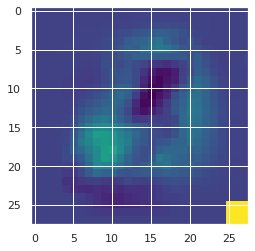

In [35]:
plt.imshow(temp, cmap='viridis')

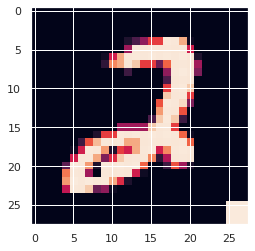

In [32]:
plt.imshow(x_train[41].reshape(28,28))

In [85]:
p_list[2]

DeviceArray([0.00000000e+00, 0.00000000e+00, 9.99999975e-05,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e

DeviceArray([[1.0000e-04, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00,
              1.0000e+00, 1.0000e+00],
             [0.0000e+00, 1.0000e-04, 0.0000e+00, ..., 1.0000e+00,
              1.0000e+00, 1.0000e+00],
             [0.0000e+00, 0.0000e+00, 1.0000e-04, ..., 1.0000e+00,
              1.0000e+00, 1.0000e+00],
             ...,
             [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.0001e+00,
              1.0000e+00, 1.0000e+00],
             [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00,
              1.0001e+00, 1.0000e+00],
             [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00,
              1.0000e+00, 1.0001e+00]], dtype=float32)

In [98]:
output_perturb = predict_fn(t=1, x_test=p_list)[0]

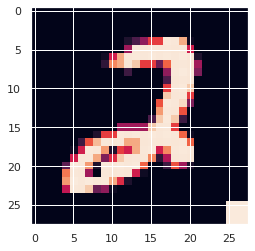

In [36]:
plt.imshow(x_train[41].reshape(28,28))

In [38]:
maps=[]


for time in tqdm(range(200)):
#     print('Time============================', time)
    maps.append(sal_map(time, x_train[41]))
    
    if time%5==0:
        onp.save('experiments_outputs_logs/single_patch_90_effective_visualization/visualization_even_corrupted.npy', maps)
    
    onp.save('experiments_outputs_logs/single_patch_90_effective_visualization/visualization_even_corrupted.npy', maps)

100%|██████████| 200/200 [33:23<00:00, 10.02s/it]


# Even non_corrupted


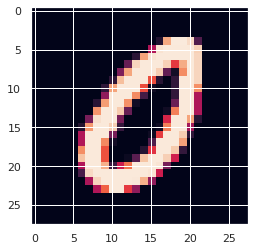

In [47]:
plt.imshow(x_train[3344].reshape(28,28))

In [48]:
maps=[]


for time in tqdm(range(200)):
#     print('Time============================', time)
    maps.append(sal_map(time, x_train[3344]))
    
    if time%5==0:
        onp.save('experiments_outputs_logs/single_patch_90_effective_visualization/visualization_even_non_corrupted.npy', maps)
    
    onp.save('experiments_outputs_logs/single_patch_90_effective_visualization/visualization_even_non_corrupted.npy', maps)


100%|██████████| 200/200 [33:16<00:00,  9.98s/it]


# odd non_corrupted

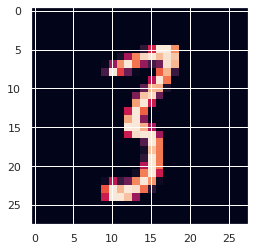

In [50]:
plt.imshow(x_train[34].reshape(28,28))

In [51]:
maps=[]


for time in tqdm(range(200)):
#     print('Time============================', time)
    maps.append(sal_map(time, x_train[34]))
    
    if time%5==0:
        onp.save('experiments_outputs_logs/single_patch_90_effective_visualization/visualization_odd.npy', maps)
    
    onp.save('experiments_outputs_logs/single_patch_90_effective_visualization/visualization_odd.npy', maps)


100%|██████████| 200/200 [33:12<00:00,  9.96s/it]


# for 100% effectiveness

In [21]:

# load noise train images:
x_data = onp.load('mnist_shortcut_dataset/mnist_x_train_orginal.npy')

#load corresponding original label:
x_label = onp.load('mnist_shortcut_dataset/y_train_original.npy')

## sample balanced training dataset 


x_train, y_train = sample_dataset(x_data, x_label, train_size)


#corrupt_images


#corrupt with 100% effective noise
x_train = corr_images(x_train, y_train, 1)


    
##convert labels to odd/even classes
y_train = y_train%2

#load clean test data and labels
x_test = np.load('mnist_shortcut_dataset/mnist_x_test_ood.npy')
y_test = np.load('mnist_shortcut_dataset/mnist_y_test_ood.npy')
x_test = x_test.reshape(-1,784)

train_images, train_labels, test_images, test_labels = load_data(x_train,y_train, x_test, y_test,
                                                                test_size=test_size)

[ 192 1883  532 2495 1698 3231 3499 3415 1821 1281 2712 1989  806  739
 2825 1436 1738  383 3274 2284 1326 2506 1411 1956 1864 1666 3525 3284
   13  833  129   10 2787  476  957 3797 3564 1241 3336 2026 2067 2599
 3419 2261 3056 1433 2391 1855 1047 2610  466  453 1538  550   64 1977
 3148 3910 2770 2053 1481 3633 2851 3598 3740 3306  898   60 3026 1963
 3885 2646 3772 1770  795 3228 3078 3183  799 3048 2643 3491 3889  962
 2109 3301 1641 2238 1897 3679 2201 3742 3235 2121 3151 1002 3815 2184
 3090 3143  713 2568 2488 2596 3734 1577 1390 1280  927  946 3393 1597
 1413 3518 1616  949 2003 1004 2681  561  154  698  362 3001  530 1449
 1180 3692 3107 2880 1484 2187 3145  716 2492 2794 1798  238 1784 1022
 1733 1160 2291  907  141 3481 3241 2269 2703  118 1846 1815 1800 2157
 1845 2337 3108 1693 1711 3953 1391  948 2948 3482  244 2574 3212 2521
 1885 3035 2410 2137 2414 2401 1100 1125 3227 3322  626 3678  540 3103
   29 1753 2016 3931 2900 1557 2460 1124 1943 1511 1783 3476 2629 3372
 3099 

In [22]:
w_std=1.5
beta=0.2
diag_reg=1e-4
compute_cov=False

init_fn, apply_fn, ker_fn = nt.stax.serial(
#             nt.stax.Conv(1, (3,3), W_std=w_std, b_std=b_std),
#             nt.stax.Relu(),
#             nt.stax.AvgPool((8,8)),

#             nt.stax.Conv(1, (3,3), W_std=w_std, b_std=b_std),
#             nt.stax.Relu(),
#             nt.stax.AvgPool((4,4)),

# #             nt.stax.Conv(6, (3,3), W_std=w_std, b_std=b_std),
# #             nt.stax.Relu(),
# #             nt.stax.AvgPool((4,4)),

#             nt.stax.Flatten(),

#             nt.stax.Dense(1, W_std=w_std, b_std=b_std))

        nt.stax.Dense(512, W_std=w_std, b_std=b_std),
        nt.stax.Relu(),
        nt.stax.Dense(128, W_std=w_std, b_std=b_std),
        nt.stax.Relu(),
        nt.stax.Dense(32, W_std=w_std, b_std=b_std),
        nt.stax.Relu(),
        nt.stax.Dense(1, W_std=w_std, b_std=b_std))

In [23]:
ker_fn = nt.batch(ker_fn, batch_size=250, device_count=num_of_gpus, store_on_device=True)
predict_fn = gradient_descent_mse_vib(beta, train_images, train_labels, diag_reg, ker_fn)
predict_fn = partial(predict_fn, get='ntk', compute_cov=compute_cov)

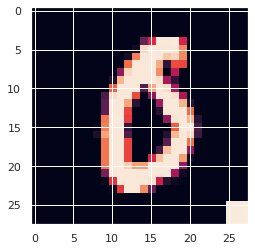

In [30]:
plt.imshow(x_train[871].reshape(28,28))

In [31]:
maps=[]


for time in tqdm(range(100)):
#     print('Time============================', time)
    maps.append(sal_map(time, x_train[871]))
    
    if time%5==0:
        onp.save('experiments_outputs_logs/single_patch_100_effective_visualization/visualization_even_corrupted.npy', maps)
    
    onp.save('experiments_outputs_logs/single_patch_100_effective_visualization/visualization_even_corrupted.npy', maps)

100%|██████████| 100/100 [16:50<00:00, 10.11s/it]


# odd ( non corrupted)


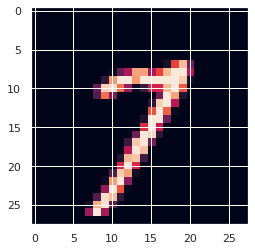

In [30]:
plt.imshow(x_train[3344].reshape(28,28))

In [31]:
maps=[]


for time in tqdm(range(200)):
#     print('Time============================', time)
    maps.append(sal_map(time, x_train[3344]))
    
    if time%5==0:
        onp.save('experiments_outputs_logs/single_patch_100_effective_visualization/visualization_odd.npy', maps)
    
    onp.save('experiments_outputs_logs/single_patch_100_effective_visualization/visualization_odd.npy', maps)


100%|██████████| 200/200 [33:04<00:00,  9.92s/it]


# for no shortcuts (0% effectiveness)

In [ ]:

# load noise train images:
x_data = onp.load('mnist_shortcut_dataset/mnist_x_train_orginal.npy')

#load corresponding original label:
x_label = onp.load('mnist_shortcut_dataset/y_train_original.npy')

## sample balanced training dataset 


x_train, y_train = sample_dataset(x_data, x_label, train_size)


#corrupt_images


#corrupt with 100% effective noise
x_train = corr_images(x_train, y_train, 0)


    
##convert labels to odd/even classes
y_train = y_train%2

#load clean test data and labels
x_test = np.load('mnist_shortcut_dataset/mnist_x_test_ood.npy')
y_test = np.load('mnist_shortcut_dataset/mnist_y_test_ood.npy')
x_test = x_test.reshape(-1,784)

train_images, train_labels, test_images, test_labels = load_data(x_train,y_train, x_test, y_test,
                                                                test_size=test_size)

In [ ]:
w_std=1.5
beta=0.2
diag_reg=1e-4
compute_cov=False

init_fn, apply_fn, ker_fn = nt.stax.serial(
#             nt.stax.Conv(1, (3,3), W_std=w_std, b_std=b_std),
#             nt.stax.Relu(),
#             nt.stax.AvgPool((8,8)),

#             nt.stax.Conv(1, (3,3), W_std=w_std, b_std=b_std),
#             nt.stax.Relu(),
#             nt.stax.AvgPool((4,4)),

# #             nt.stax.Conv(6, (3,3), W_std=w_std, b_std=b_std),
# #             nt.stax.Relu(),
# #             nt.stax.AvgPool((4,4)),

#             nt.stax.Flatten(),

#             nt.stax.Dense(1, W_std=w_std, b_std=b_std))

        nt.stax.Dense(512, W_std=w_std, b_std=b_std),
        nt.stax.Relu(),
        nt.stax.Dense(128, W_std=w_std, b_std=b_std),
        nt.stax.Relu(),
        nt.stax.Dense(32, W_std=w_std, b_std=b_std),
        nt.stax.Relu(),
        nt.stax.Dense(1, W_std=w_std, b_std=b_std))

In [1]:
plt.imshow(x_train[1227].reshape(28,28))

NameError: name 'plt' is not defined

In [56]:
maps=[]


for time in tqdm(range(200)):
#     print('Time============================', time)
    maps.append(sal_map(time, x_train[1227]))
    
    if time%5==0:
        onp.save('experiments_outputs_logs/single_patch_0_effective_visualization/visualization_even_corrupted.npy', maps)
    
    onp.save('experiments_outputs_logs/single_patch_0_effective_visualization/visualization_even_corrupted.npy', maps)

 70%|██████▉   | 139/200 [29:13<12:49, 12.61s/it]


KeyboardInterrupt: 

In [ ]:
# for odd

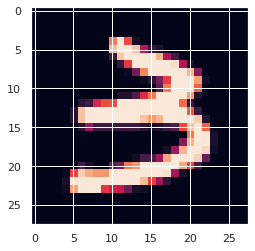

In [57]:
plt.imshow(x_train[19].reshape(28,28))

In [58]:
maps=[]


for time in tqdm(range(200)):
#     print('Time============================', time)
    maps.append(sal_map(time, x_train[19]))
    
    if time%5==0:
        onp.save('experiments_outputs_logs/single_patch_0_effective_visualization/visualization_odd.npy', maps)
    
    onp.save('experiments_outputs_logs/single_patch_0_effective_visualization/visualization_odd.npy', maps)

100%|██████████| 200/200 [44:05<00:00, 13.23s/it]
